In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 36, 3, 1)
        self.conv2 = nn.Conv2d(36, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 144)
        self.fc2 = nn.Linear(144, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
# Load the MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=64)


In [8]:
# Instantiate the model
model = Net()


In [9]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [10]:
# Training loop
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [11]:
# Evaluation function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))


In [12]:
# Training and evaluation loop
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)
torch.save(model.state_dict(), 'mnist_cnn_model.pth')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310257
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.219119
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.264288
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.272118
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.036874
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.072236
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.106787
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.066390
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164813
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.164826

Test set: Average loss: 0.0007, Accuracy: 9865/10000 (98.65%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034937
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.013432
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.077847
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.178972
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.100792
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.048615
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.080254
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.039996
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.02520

In [14]:
import cv2
import matplotlib.pyplot as plt

In [15]:
# Create an instance of 'Net' and move it to the same device as the original model
loaded_net = Net().to(device)

# Load the saved state dictionary
checkpoint = torch.load('mnist_cnn_model.pth')

# Load the state dictionary into 'Net'
loaded_net.load_state_dict(checkpoint)

<All keys matched successfully>

In [16]:
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')

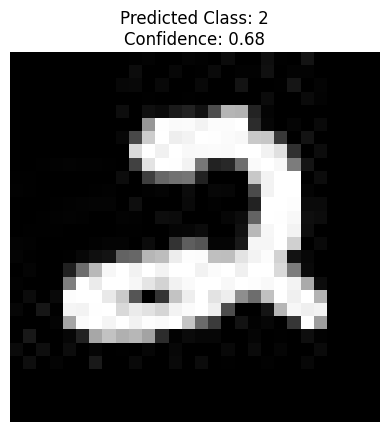

In [17]:
input_image = cv2.imread("img_1.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])
input_image = transform(input_image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# Show the image and prediction
plt.imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

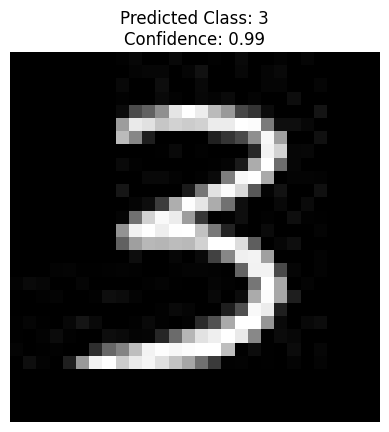

In [18]:
input_image = cv2.imread("img_2.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(input_image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# Show the image and prediction
plt.imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

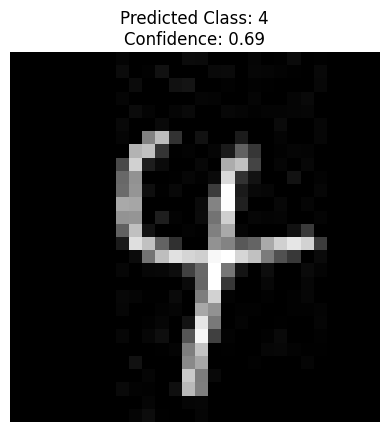

In [19]:
input_image = cv2.imread("img_3.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])
input_image = transform(input_image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# Show the image and prediction
plt.imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()